In [1]:
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import hub
from torch.utils.data import Dataset, DataLoader
import torchaudio

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score, recall_score, precision_score, balanced_accuracy_score, accuracy_score

import scipy

from tqdm import tqdm

from datasets import load_dataset, Dataset, Audio
import librosa
from transformers import AutoFeatureExtractor

from models.basic_transformer import BasicTransformer

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEQUENCE_LENGTH = 6_000
MFCC = 128
print(f"It's {DEVICE} time!!!")

It's cuda time!!!


In [3]:
DATA_DIR = os.path.join('..', 'data')
VOICES_DIR = os.path.join(DATA_DIR, 'Voices_wav')
APHASIA_DIR = os.path.join(VOICES_DIR, 'Aphasia')
NORM_DIR = os.path.join(VOICES_DIR, 'Norm')

In [4]:
meta_data_aphasia = pd.read_excel(os.path.join(DATA_DIR, "Demo RAT discourse production.xlsx"), sheet_name='пациенты')
meta_data_norm = pd.read_excel(os.path.join(DATA_DIR, "Demo RAT discourse production.xlsx"), sheet_name='норма')

meta_data_norm.drop(meta_data_norm.index[-1], axis=0, inplace=True)

In [5]:
meta_data_aphasia.rename(columns={'Stroked hemisphere (L/R/LR)': 'Stroked hemisphere',
                          'Aphasia/Norm (A/N), A includes all patients, even with just dysarthria': 'Aphasia/Norm', 
                          'Aphasia_Severity \n0 - no aphasia\n1 - very mild\n2 - mild\n3 - mild-moderate\n4 - moderate\n5 - moderate-severe\n6 - severe\n7 - very severe': 'Aphasia_Severity',
                          'Aphasia_Types\n1 - efferent motor\n2 - afferent motor\n3 - complex motor\n4 - dynamic\n5 - acoustic-mnestic\n6 - sensory\n7 - semantic\n8 - other': 'Aphasia_Types',
                          'Dominant_Aphasia\n1 - efferent motor\n2 - afferent motor\n3 - complex motor\n4 - dynamic\n5 - acoustic-mnestic\n6 - sensory\n7 - semantic\n8 - other': 'Dominant_Aphasia',
                          'Dysarthria (1/0)': 'Dysarthria',
                          'Dysarthria_Severity \n0 - no dysarthria\n1 - very mild\n2 - mild\n3 - mild-moderate\n4 - moderate\n5 - moderate-severe\n6 - severe\n7 - very severe': 'Dysarthria_Severity',
                          }, inplace=True)

In [6]:
print(f"Participants with aphasia: {len(meta_data_aphasia)}")
print(f"Participants with norm: {len(meta_data_norm)}")

Participants with aphasia: 353
Participants with norm: 101


In [7]:
all_data = {"filename": [], "label": []}

for filename in os.listdir(APHASIA_DIR):
    all_data["filename"].append(filename)
    all_data["label"].append(1)
    
for filename in os.listdir(NORM_DIR):
    all_data["filename"].append(filename)
    all_data["label"].append(0)
    
all_data = pd.DataFrame(all_data)

In [8]:
dataset = Dataset.from_pandas(all_data)
dataset = dataset.class_encode_column("label")

Stringifying the column:   0%|          | 0/810 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/810 [00:00<?, ? examples/s]

In [9]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base", sampling_rate=8_000, )

In [10]:
def convert_to_path(example):
    if example["label"] == 0:
        example['signal'] = os.path.join(NORM_DIR, example["filename"])
    elif example["label"] == 1:
        example['signal'] = os.path.join(APHASIA_DIR, example["filename"])
    return example

dataset = dataset.map(convert_to_path).cast_column("signal", Audio(sampling_rate=8_000))

Map:   0%|          | 0/810 [00:00<?, ? examples/s]

In [11]:
mfcc_class = torchaudio.transforms.MFCC(sample_rate=8_000, n_mfcc=MFCC, log_mels=True, melkwargs={"n_fft": 600, "win_length": 400, "hop_length": 200, "n_mels": 200})

def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["signal"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=SEQUENCE_LENGTH, truncation=True, padding="max_length"
    )
    return inputs

def preprocess_function_mfcc(examples):
    # audio_arrays = [nn.functional.pad(mfcc_class(torch.Tensor(x["array"]))[..., :SEQUENCE_LENGTH]) for x in examples["signal"]]
    # print(audio_arrays[0])
    # print(torch.Tensor(audio_arrays).shape)
    # inputs = mfcc_class(torch.Tensor(audio_arrays))
    audio_arrays = []
    for x in examples:
        mfcc = mfcc_class(torch.Tensor(x["array"]))[..., :SEQUENCE_LENGTH]
        
        mfcc = nn.functional.pad(mfcc, (0, SEQUENCE_LENGTH - mfcc.shape[-1]), mode="constant")
        audio_arrays.append(mfcc.numpy())
    return torch.Tensor(audio_arrays)

In [12]:
# dataset.set_transform(transforms.Compose([transforms.ToTensor(),
#                                                     torchaudio.transforms.TimeMasking(time_mask_param=100, iid_masks=True, p=0.5)]))
# dataset = dataset.map(preprocess_function_mfcc, remove_columns="signal", batched=True)
# dataset = dataset.rename_column("input_values", "signal")

In [13]:
# dataset = dataset.map(preprocess_function_mfcc, remove_columns="signal", batched=True)
# dataset = dataset.rename_column("input_values", "signal")

In [14]:
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="label")
dataset_test = dataset['test']
dataset = dataset['train']
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="label")

In [15]:
SEED = 1984

np.random.seed(SEED)
torch.manual_seed(SEED)

gen = torch.Generator()
gen.manual_seed(SEED)

def split_into_windows(signal, window_size=20 * 8000, step=20 * 8000):
    return [signal[i : i + window_size] for i in range(0, len(signal) - window_size + 1, step)]


def collate_batch(batch):
    time_series = list(map(lambda item: item["signal"], batch))
    target = list(map(lambda item: item['label'], batch))
    
    return time_series, torch.tensor(target)

def warmup_then_cosine_annealing_lr(optimizer, start_factor, total_steps, warmup_dur):
    warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=start_factor, end_factor=1.0, total_iters=warmup_dur)
    cos_annealing = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps - warmup_dur)
    warnup_then_cos_anneal = torch.optim.lr_scheduler.SequentialLR(optimizer, [warmup, cos_annealing], milestones=[warmup_dur])
    return warnup_then_cos_anneal

def train_model(model, dataset_train, dataset_val, epochs=1, lr=0.001, shuffle_train=False, device="cpu"):
      
    model = model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    dl_train = DataLoader(dataset_train, batch_size=32, shuffle=shuffle_train, drop_last=True, collate_fn=collate_batch, generator=gen, num_workers=4)
    dl_val = DataLoader(dataset_val, batch_size=32, shuffle=False, drop_last=True, collate_fn=collate_batch, generator=gen, num_workers=4)
        
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    for epoch in tqdm(range(epochs), desc="Training model"):
        model.train()
        total_train_loss = 0
        total_val_loss = 0
        
        train_acc = []
        val_acc = []
        for ts, target in dl_train:
            ts = preprocess_function_mfcc(ts)
            ts = ts.permute(0, 2, 1)
            ts, target = ts.to(device), target.to(device)
            optimizer.zero_grad()
            
            output = model(ts)
            
            # train_acc.append(torch.tensor(torch.argmax(output, dim=1) == target).cpu().detach().numpy())
            preds = torch.argmax(output, dim=1).cpu().detach().numpy()
            train_acc.append(accuracy_score(target.cpu().detach().numpy(), preds))
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.detach().item()
        
        avg_train_acc = np.stack(train_acc, axis=0).mean()

        avg_train_loss = total_train_loss / len(dataset_train)
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
                
        model.eval()
        
        with torch.no_grad():
            for ts, target in dl_val:
                ts = preprocess_function_mfcc(ts)
                ts = ts.permute(0, 2, 1)
                ts, target = ts.to(device), target.to(device)
                
                output = model(ts)
                
                preds = torch.argmax(output, dim=1).cpu().detach().numpy()
                val_acc.append(accuracy_score(target.cpu().detach().numpy(), preds))
                loss = criterion(output, target)
                total_val_loss += loss.detach().item()
        
        avg_val_acc = np.stack(val_acc, axis=0).mean()
        avg_val_loss = total_val_loss / len(dataset_val)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)
        
        if epoch % 10 == 0:
            # print(f'Epoch {epoch}, train_Loss: {avg_train_loss:.3f}, avg_train_acc: {avg_train_acc:.2f}, test_Loss: {avg_val_loss:.3f}, test_acc: {avg_val_acc:.2f}', )
            tqdm.write(f"Epoch {epoch}: train loss: {avg_train_loss:.3f}, train balanced acc: {avg_train_acc:.2f}, test loss: {avg_val_loss:.3f}, test balanced acc: {avg_val_acc:.2f}")

            
    return model, train_loss_list, val_loss_list, train_acc_list, val_acc_list


In [16]:
transformer = BasicTransformer(input_dim=MFCC, sequence_length=SEQUENCE_LENGTH, hidden_dim=32, num_layers=10, num_heads=4, num_classes=2, dropout=0.1)

In [17]:
transformer, train_l, val_l, train_accuracy, val_accuracy = train_model(transformer, dataset["train"], dataset["test"], epochs=40, lr=1e-6, shuffle_train=True, device=DEVICE)

Training model:   2%|▎         | 1/40 [00:55<36:13, 55.74s/it]

Epoch 0: train loss: 0.023, train balanced acc: 0.25, test loss: 0.024, test balanced acc: 0.25


Training model:  28%|██▊       | 11/40 [10:05<26:30, 54.85s/it]

Epoch 10: train loss: 0.022, train balanced acc: 0.32, test loss: 0.022, test balanced acc: 0.34


Training model:  52%|█████▎    | 21/40 [19:15<17:22, 54.89s/it]

Epoch 20: train loss: 0.021, train balanced acc: 0.75, test loss: 0.020, test balanced acc: 0.75


Training model:  78%|███████▊  | 31/40 [28:23<08:14, 54.92s/it]

Epoch 30: train loss: 0.020, train balanced acc: 0.75, test loss: 0.019, test balanced acc: 0.75


Training model: 100%|██████████| 40/40 [36:36<00:00, 54.92s/it]


In [18]:
def test_model(model, test_data):
    model = model.to("cpu")
        
    model.eval()
    preds = []
    with torch.no_grad():
        for sgnl, target in zip(test_data["signal"], test_data["label"]):
            sgnl = preprocess_function_mfcc([sgnl])
            sgnl = sgnl.permute(0, 2, 1)

            label = model(sgnl).to("cpu").detach().numpy().squeeze()
            preds.append(label.argmax(axis=-1))
    preds = np.array(preds)
    
    print(f"Accuracy: {accuracy_score(test_data["label"], preds)}")
    print(f"F1 Score: {f1_score(test_data["label"], preds)}")
    print(f"Recall: {recall_score(test_data["label"], preds)}")
    print(f"Precision: {precision_score(test_data["label"], preds)}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(test_data["label"], preds)}")
    return preds

In [19]:
test_model(transformer, dataset_test)

Accuracy: 0.7222222222222222
F1 Score: 0.7945205479452054
Recall: 0.7131147540983607
Precision: 0.8969072164948454
Balanced Accuracy: 0.7315573770491803


array([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1])

Text(0.5, 0, 'Epoch')

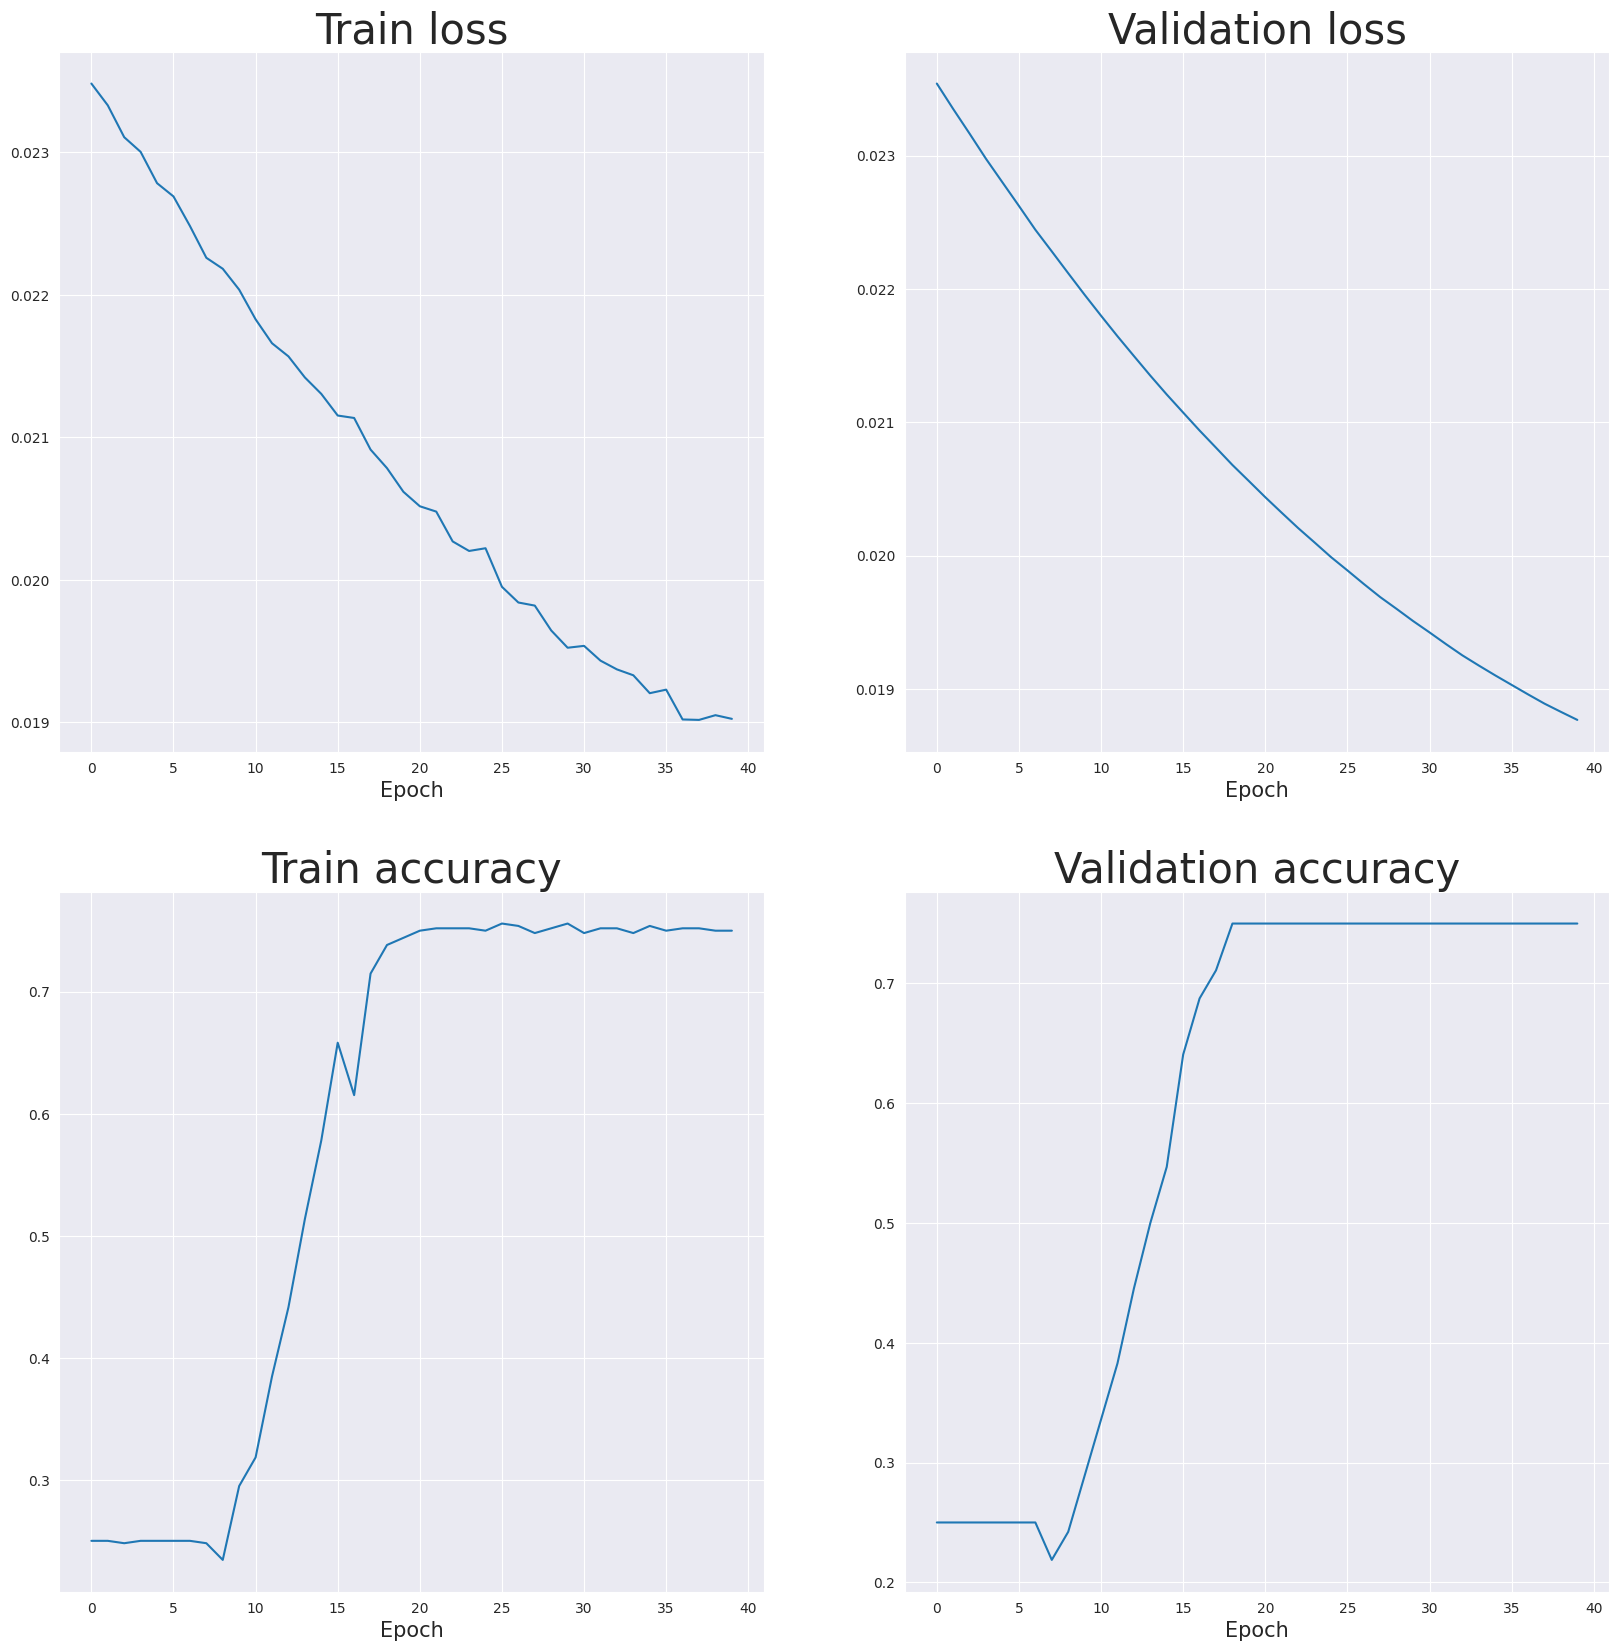

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

axes[0][0].plot(train_l)
axes[0][0].set_title("Train loss", fontsize=30)
axes[0][0].set_xlabel("Epoch", fontsize=15)

axes[0][1].plot(val_l)
axes[0][1].set_title("Validation loss", fontsize=30)
axes[0][1].set_xlabel("Epoch", fontsize=15)

axes[1][0].plot(train_accuracy)
axes[1][0].set_title("Train accuracy", fontsize=30)
axes[1][0].set_xlabel("Epoch", fontsize=15)

axes[1][1].plot(val_accuracy)
axes[1][1].set_title("Validation accuracy", fontsize=30)
axes[1][1].set_xlabel("Epoch", fontsize=15)